In [57]:
DATA_BASEPATH = '../data'

In [58]:
import os

import pandas as pd
import numpy as np

# Les ID sont des np.ulonglong parce que pd.UInt64Dtype() provoque un bug si utilisé dans la colonne d'index
# (BooleanArray does not have member "sum", quelque chose comme ça)...
functions = pd.read_csv(
    os.path.join(DATA_BASEPATH, 'functions.txt'),
    names=['id', 'name', 'runtime', 'image', 'parameters', 'input_kind'],
    index_col='id',
    dtype={'id': np.ulonglong, 'name': pd.StringDtype(), 'runtime': pd.StringDtype(),
           'image': pd.StringDtype(), 'parameters': pd.StringDtype(), 'input_kind': pd.StringDtype()},
    lineterminator=';',
    na_values='\\N')
functions['name'] = functions['name'].map(lambda n: n.split('/')[-1])
runs = pd.read_csv(
    os.path.join(DATA_BASEPATH, 'runs.txt'),
    names=['id', 'function', 'namespace', 'activation_id', 'failed', 'start_ms', 'end_ms', 'wait_ms',
           'init_ms', 'error_msg'],
    index_col='id',
    dtype={'id': np.ulonglong, 'function': pd.UInt64Dtype(), 'namespace': pd.StringDtype(),
           'activation_id': pd.StringDtype(), 'failed': pd.BooleanDtype(), 'start_ms': pd.UInt64Dtype(),
           'end_ms': pd.UInt64Dtype(), 'wait_ms': pd.UInt64Dtype(), 'init_ms': pd.UInt64Dtype(),
           'error_msg': pd.StringDtype()},
    lineterminator=';',
    na_values='\\N')
parameters = pd.read_csv(
    os.path.join(DATA_BASEPATH, 'parameters.txt'),
    names=['id', 'run', 'name', 'value'],
    index_col='id',
    dtype={'id': np.ulonglong, 'run': pd.UInt64Dtype(), 'name': pd.StringDtype(), 'value': pd.StringDtype()},
    lineterminator=';',
    na_values='\\N')
results = pd.read_csv(
    os.path.join(DATA_BASEPATH, 'results.txt'),
    names=['id', 'run', 'name', 'value'],
    index_col='id',
    dtype={'id': np.ulonglong, 'run': pd.UInt64Dtype(), 'name': pd.StringDtype(), 'value': pd.StringDtype()},
    lineterminator=';',
    na_values='\\N')
resources = pd.read_csv(
    os.path.join(DATA_BASEPATH, 'resources.txt'),
    names=['id', 'run', 'timestamp_ms', 'counter', 'value'], index_col='id',
    dtype={'id': np.ulonglong, 'run': pd.UInt64Dtype(), 'timestamp_ms': pd.UInt64Dtype(), 'counter': pd.StringDtype(),
           'value': pd.Float32Dtype()},
    lineterminator=';',
    na_values='\\N')

# print(functions)
# print(functions.dtypes)
# print(runs)
# print(runs.dtypes)
# print(parameters)
# print(parameters.dtypes)
# print(results)
# print(results.dtypes)
# print(resources)
# print(resources.dtypes)

# Généralités

In [59]:
used_functions = set(functions.index) & set(runs.function)
print(f'{len(functions.index)} unique functions, {len(used_functions)} used:\n\t- ' + '\n\t- '.join(
    f'{functions.loc[func_id]["name"]} ({len(runs[runs.function == func_id])} runs)' for func_id in used_functions))

runs_failed = runs[runs.failed]
print(f'{len(runs.index)} runs, {len(runs_failed)} failed ({len(runs_failed) / len(runs.index):%})')

most_run_function = runs.groupby('function').size().idxmax()
print(f'Most run function: {functions.loc[most_run_function]["name"]}')
if len(runs_failed) > 0:
    most_failed_function = runs[runs.failed].groupby('function').size().idxmax()
    print(f'Most failed function: {functions.loc[most_failed_function]["name"]}')
biggest_user = runs.groupby('namespace').size().idxmax()
print(f'Biggest user: {biggest_user}')

22 unique functions, 4 used:
	- sharp_blur (85 runs)
	- sharp_sepia (87 runs)
	- sharp_resize (6 runs)
	- pydub_effects (29 runs)
207 runs, 29 failed (14.009662%)
Most run function: sharp_sepia
Most failed function: pydub_effects
Biggest user: user001


# Utilisation des ressources par les fonctions

## Utilisation de la mémoire par chaque fonction

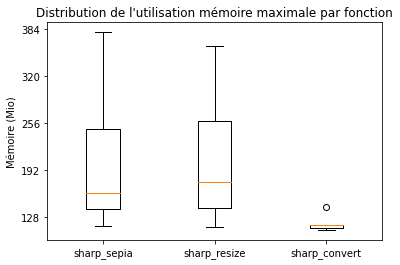

In [60]:
import matplotlib.pyplot as plt
import matplotlib.ticker as pltticker

max_mem_per_run_per_func = resources[resources.counter == 'memory'].join(runs['function'], on='run', how='inner').groupby(['function', 'run'])[['value']].max()

_, axes = plt.subplots()

axes.set_title('Distribution de l\'utilisation mémoire maximale par fonction')
axes.set_ylabel('Mémoire (Mio)')

func_ids, max_mem_per_func = zip(*list(max_mem_per_run_per_func.groupby('function')['value']))

axes.boxplot(list(max_mem_per_func), labels=functions.iloc[list(func_ids)]['name'])

axes.yaxis.set_major_locator(pltticker.MultipleLocator(base=64 * 1024 * 1024))
axes.yaxis.set_major_formatter(pltticker.FuncFormatter(lambda y, pos: int(y / (1024 * 1024))))

## Distribution de l'utilisation de la mémoire pour toutes les fonctions

_TODO_

# Interaction entre les fonctions

## Impact sur le temps d'exécution

_TODO_

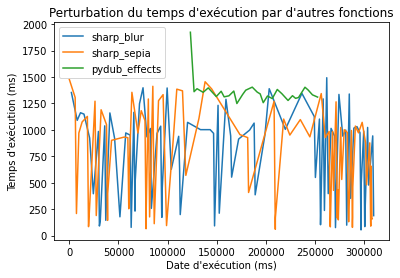

In [61]:
import matplotlib.pyplot as plt

LONGTERM_FUNCTIONS_NAMES = [
    'sharp_blur',
    'sharp_sepia'
]
PERTURBATOR_FUNCTION_NAME = 'pydub_effects'

longterm_func_ids = functions.index[functions.name.isin(LONGTERM_FUNCTIONS_NAMES)]
perturbator_func_id = functions.index[functions.name==PERTURBATOR_FUNCTION_NAME][0]

expe_start_ms = runs.start_ms.min()

runs_duration = pd.DataFrame({'function': runs['function'], 'start_ms': runs['start_ms'] - expe_start_ms, 'duration_ms': runs['end_ms'] - runs['start_ms']}, index=runs.index)

_, axes = plt.subplots()

axes.set_title('Perturbation du temps d\'exécution par d\'autres fonctions')
axes.set_xlabel('Date d\'exécution (ms)')
axes.set_ylabel('Temps d\'exécution (ms)')

for func_id, func_data in runs_duration[runs_duration.function.isin(longterm_func_ids)].groupby('function'):
    axes.plot(list(func_data['start_ms']), list(func_data['duration_ms']), label=functions.loc[func_id]['name'])

axes.plot(list(runs_duration[runs_duration['function']==perturbator_func_id]['start_ms']), list(runs_duration[runs_duration['function']==perturbator_func_id]['duration_ms']), label=functions.loc[perturbator_func_id]['name'])

axes.legend()

## Impact sur le délai d'exécution

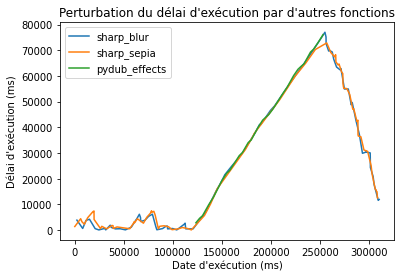

In [62]:
import matplotlib.pyplot as plt

LONGTERM_FUNCTIONS_NAMES = [
    'sharp_blur',
    'sharp_sepia'
]
PERTURBATOR_FUNCTION_NAME = 'pydub_effects'

longterm_func_ids = functions.index[functions.name.isin(LONGTERM_FUNCTIONS_NAMES)]
perturbator_func_id = functions.index[functions.name==PERTURBATOR_FUNCTION_NAME][0]

expe_start_ms = runs.start_ms.min()

runs_wait = pd.DataFrame({'function': runs['function'], 'start_ms': runs['start_ms'] - expe_start_ms, 'wait_ms': runs['wait_ms']}, index=runs.index)

_, axes = plt.subplots()

axes.set_title('Perturbation du délai d\'exécution par d\'autres fonctions')
axes.set_xlabel('Date d\'exécution (ms)')
axes.set_ylabel('Délai d\'exécution (ms)')

for func_id, func_data in runs_wait[runs_duration.function.isin(longterm_func_ids)].groupby('function'):
    axes.plot(list(func_data['start_ms']), list(func_data['wait_ms']), label=functions.loc[func_id]['name'])

axes.plot(list(runs_wait[runs_duration['function']==perturbator_func_id]['start_ms']), list(runs_wait[runs_duration['function']==perturbator_func_id]['wait_ms']), label=functions.loc[perturbator_func_id]['name'])

axes.legend()